In [1]:
%matplotlib inline

# Introduction

Building on the work from `3_compare_classes.ipynb`, in this notebook, we aim to derive an optimal wavelength range where the correlation between flux and luminosity remains sufficiently strong. The goal being to provide a suite of observing windows for class 0 and 1 protostellar objects, rather than a singular entry point.

# Import Dependencies

In [2]:
# System & OS
import warnings
warnings.filterwarnings('ignore')

# Data Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Mount Storage

`cd` to the `data/` directory.

In [3]:
%cd '../data/'

/Users/zach/Documents/Python/Protostellar-Luminosity/data


# Feature Engineering

Read in our results from `2_linear_regression.ipynb`.

In [4]:
# Read in linear coefficients
coef = pd.read_csv('lin_coef.csv', skiprows=1, names=['Class', 
                                                      'Wavelength (microns)', 
                                                      'Slope', 
                                                      'Unc_slope', 
                                                      'Intercept', 
                                                      'Unc_intercept'])
# Read in correlation metrics
corr = pd.read_csv('corr_coef.csv', skiprows=1, names=['Class', 
                                                       'Wavelength (microns)', 
                                                       'Reduced chi-squared (linear space)', 
                                                       'Reduced chi-squared (log10 space)', 
                                                       'Correlation coefficient (linear space)', 
                                                       'Correlation coefficient (log10 space)'])

# Merge the two dataframes along the class and wavelength columns
df = pd.merge(coef, corr, on=['Class', 'Wavelength (microns)'])
df

,Class,Wavelength (microns),Slope,Unc_slope,Intercept,Unc_intercept,Reduced chi-squared (linear space),Reduced chi-squared (log10 space),Correlation coefficient (linear space),Correlation coefficient (log10 space)
0,0,36000.29516661664,0.205222,0.001546,-18.520233,0.002017,nan,-1.193127e+01,0.477976,0.748775
1,1a,36000.29516661664,0.344443,0.000991,-18.817223,0.001138,nan,-1.848508e+01,0.343043,0.887259
2,1b,36000.29516661664,0.594088,0.001722,-19.119119,0.001299,nan,-4.768334e+01,0.434630,0.886253
3,All,36000.29516661664,0.457110,0.001066,-18.954541,0.001106,nan,-1.500133e+02,0.222630,0.836356
4,0,24000.196777744422,0.218374,0.001342,-17.695543,0.001752,nan,-9.434475e+00,0.576396,0.810642
...,...,...,...,...,...,...,...,...,...,...
399,All,0.050000409953634216,8.579801,0.078281,-47.486629,0.083609,nan,-1.986639e+05,0.068419,0.418470
400,0,All,0.931400,0.005067,-11.827745,0.006656,nan,-1.984456e+06,0.504110,0.157855
401,1a,All,0.982002,0.003401,-11.474304,0.003913,nan,-3.705078e+06,0.571380,0.158788
402,1b,All,1.012902,0.003656,-11.380369,0.002766,nan,-3.584868e+06,0.669250,0.152804


Since we concluded previously that the correlation doesn't change significantly across classes, it suffices to only consider the data at `Class == 'All'`. Accordingly, we can also drop the data at `Wavelength == 'All'`, as it doesn't hold any meaningful information.

In [5]:
# Drop rows where Class != 'All'
df = df[df['Class'] == 'All']
# Drop rows where Wavelength (microns) == 'All'
df.drop(index=403, inplace=True)
# Reset index
df.reset_index(drop=True, inplace=True)

# Handle Missing Values

Furthermore, notice that the `Reduced chi-squared (linear space)` column contains only `NaN` values. Hence, we opt to drop the column from consideration. This is not terribly concerning, since our main focus will be on the data inside `log10` space.

In [6]:
# Drop columns with NaN values
df.drop(columns='Reduced chi-squared (linear space)', inplace=True)

# Outlier Detection

Finally, before beginning our analyses, notice the outlier in the following boxplot of `Reduced chi-squared (log10 space)` values.

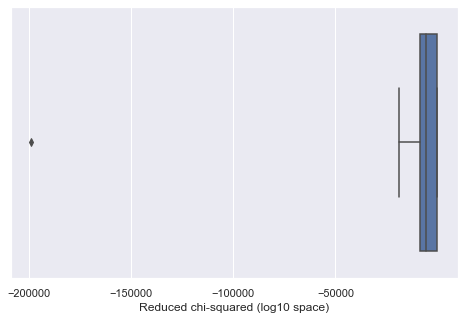

In [7]:
# Make plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x=df['Reduced chi-squared (log10 space)'], ax=ax)
# Customize plot
ax.set_xticks(range(-200000, 0, 50000))
sns.set_style('darkgrid')
# Display figure
plt.show()

This corresponds to the final row of our dataframe (`index=99`).

In [8]:
df.tail()

,Class,Wavelength (microns),Slope,Unc_slope,Intercept,Unc_intercept,Reduced chi-squared (log10 space),Correlation coefficient (linear space),Correlation coefficient (log10 space)
95,All,0.2500020497681711,1.630436,0.009861,-13.685973,0.010334,-16251.317989,0.090796,0.524678
96,All,1.000008199072,0.596907,0.006827,-9.904205,0.007099,-11638.138915,0.667610,0.298847
97,All,0.4000032796290737,1.161575,0.009316,-11.618105,0.009717,-17869.732545,0.109263,0.414432
98,All,0.700005737015892,0.739158,0.007685,-10.250403,0.007997,-14088.912098,0.373893,0.326713
99,All,0.050000409953634216,8.579801,0.078281,-47.486629,0.083609,-198663.860003,0.068419,0.418470


Due to the eccentric nature of this observation, we choose to drop the row from subsequent analyses.

In [9]:
# Drop rows with extreme outliers
df.drop(index=99, inplace=True)

# Data Analysis

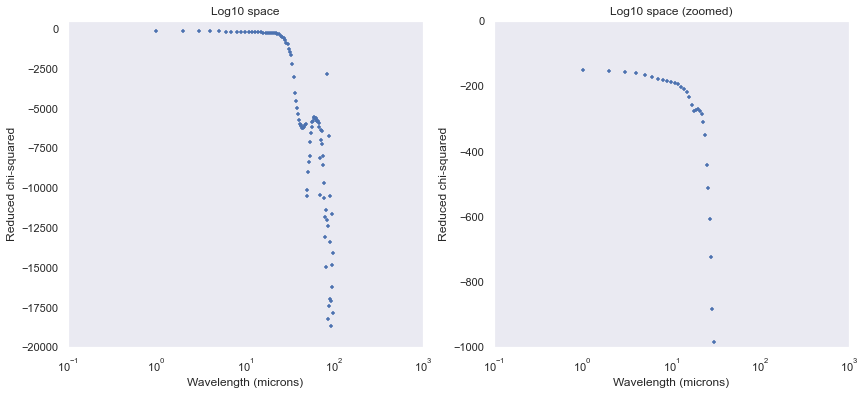

In [10]:
# Set plot style
sns.set_style('dark')
# Create 2-figure plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Plot reduced chi-squared against wavelength
ax[0].scatter(df['Wavelength (microns)'], df['Reduced chi-squared (log10 space)'], s=10, marker='+')
# Customize plot
ax[0].set_title('Log10 space')
ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reduced chi-squared')
ax[0].set_xscale('log')
ax[0].set_xlim([1e-1, 1e3])
ax[0].set_ylim([-20000, 500])
# Zoom in on the region of interest
ax[1].scatter(df['Wavelength (microns)'], df['Reduced chi-squared (log10 space)'], s=10, marker='+')
# Repeat customizations
ax[1].set_title('Log10 space (zoomed)')
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_ylabel('Reduced chi-squared')
ax[1].set_xscale('log')
ax[1].set_xlim([1e-1, 1e3])
ax[1].set_ylim([-1000, 0])
# Save figure
plt.savefig(f'Figures/chi_sq.eps', format='eps', dpi=1200)
plt.savefig(f'../src/images/chi_sq.jpg', format='jpg')
# Display figure
plt.show()

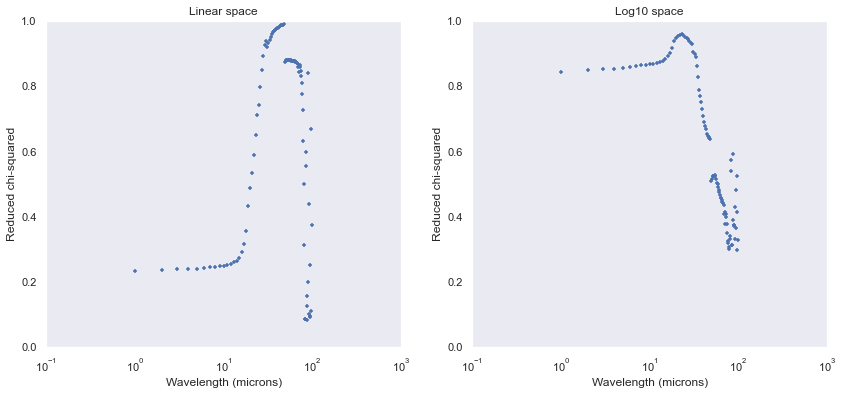

In [11]:
# Set plot style
sns.set_style('dark')
# Create 2-figure plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Plot correlation coefficient in linear space against wavelength
ax[0].scatter(df['Wavelength (microns)'], df['Correlation coefficient (linear space)'], s=10, marker='+')
# Customize plot
ax[0].set_title('Linear space')
ax[0].set_xlabel('Wavelength (microns)')
ax[0].set_ylabel('Reduced chi-squared')
ax[0].set_xscale('log')
ax[0].set_xlim([1e-1, 1e3])
ax[0].set_ylim([0, 1])
# Plot correlation coefficient in log10 space against wavelength
ax[1].scatter(df['Wavelength (microns)'], df['Correlation coefficient (log10 space)'], s=10, marker='+')
# Repeat customizations
ax[1].set_title('Log10 space')
ax[1].set_xlabel('Wavelength (microns)')
ax[1].set_ylabel('Reduced chi-squared')
ax[1].set_xscale('log')
ax[1].set_xlim([1e-1, 1e3])
ax[1].set_ylim([0, 1])
# Save figure
plt.savefig(f'Figures/corr_coef.eps', format='eps', dpi=1200)
plt.savefig(f'../src/images/corr_coef.jpg', format='jpg')
# Display figure
plt.show()